## 机器学习纳米学位毕业项目

## 项目：猫狗大战


### 项目内容

猫狗大战项目是kaggle上的一个竞赛题目：[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)，目标是训练一个模型从给定的彩色图片中分辨出是猫还是狗，本质上是二分类问题（狗的类别是1，猫的类别是0）。本项目将利用keras提供的深度神经网络学习架构对训练数据集进行建模训练，然后对测试集的数据进行预测。  

模型评价的衡量指标要求采用[对数损失函数](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition#evaluation)，目标达到[kaggle Public Leaderboard](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/leaderboard)的前10%，即小于0.06129。  

要求可以复现，设置了随机种子2019。

我们将这个notebook分为不同的步骤，你可以使用下面的链接来浏览此notebook。

* [Step 0](#step0): 获取数据集
* [Step 1](#step1): 探索数据集
* [Step 2](#step2): 图像分类存放
* [Step 3](#step3): 异常值检测
* [Step 4](#step4): 数据集预处理
* [Step 5](#step5): 模型构建与训练
* [Step 6](#step6): 模型改进
* [Step 7](#step7): 模型预测与评估




---

<a id='step0'></a>
## 步骤 0: 获取数据集
数据集需要登录Kaggle网站才有权限，请自行访问[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)下载，下载后得到一个压缩文件all.zip。

<a id='step1'></a>
## 步骤 1: 探索数据集
原始all.zip中包含测试集train.zip, test.zip和提交模板sample_submission.csv。解压train.zip和test.zip后分别得到train和test目录，其中train目录中包含25000张图片，猫和狗各12500张，文件名含标签，图片大小不一；test目录中猫和狗的图片共12500张，文件名不含标签，图片大小不一。

In [1]:
import zipfile
from tqdm import tqdm

def extract_zip_file(zip_file_name):
    '''
    # 解压一个zip文件，并实时显示进度
    '''
    with zipfile.ZipFile(zip_file_name, 'r') as zip_file:
        for file in tqdm(zip_file.namelist(), desc="Extract file " + zip_file_name):
            zip_file.extract(file, r"./")

In [ ]:
# 由于在jupyter notebook中解压太慢，此步在本地执行
# extract_zip_file("all.zip")
# extract_zip_file("train.zip")
# extract_zip_file("test.zip")

In [2]:
import os
from glob import glob
import numpy as np

working_path = os.getcwd()
org_train_path = os.path.join(working_path, "train" + os.sep)
org_test_path = os.path.join(working_path, "test" + os.sep)

org_train_files = np.array(glob(org_train_path + "*.jpg"))
org_test_files = np.array(glob(org_test_path + "*.jpg"))

n_org_train_files = org_train_files.size
n_org_test_files = org_test_files.size

# 打印数据集的数据量
print("There are {} images in training set.".format(n_org_train_files))
print("There are {} images in testing set.".format(n_org_test_files))

There are 24 images in training set.
There are 10 images in testing set.


In [51]:
import cv2  
from math import ceil
import matplotlib.pyplot as plt  
%matplotlib inline

def show_img(img_path, show_shape=False):
    '''
    # 显示一张RGB图片
    '''
    # 加载彩色（通道顺序为BGR）图像
    img = cv2.imread(img_path)
    # 将BGR图像转变为RGB图像以打印
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    # 设置图片标题
    if show_shape:
        plt.title(os.path.basename(img_path) + "\n " + str(img.shape))
    else:
        plt.title(os.path.basename(img_path))
    # 屏蔽坐标轴和刻度
    plt.axis("off")
    

def show_imgs(img_paths, idx_list, show_shape=False, figsize=(15.0, 6.0), n_cols=5):
    '''
    # 显示指定目录下索引序列分别对应的图像
    # img_paths: 图片文件名列表
    # idx_list: 指定索引列表
    # show_shape：标题中是否带图片大小信息（weight * height * channel）
    # figsize：画布大小
    # n_cols：每行显示的图片的张数和索引数的较小者
    # figsize和n_cols的存在主要是为了适应不同的显示设备，方便用户自己根据效果微调
    '''
    n_idx = len(idx_list)
    if n_idx < n_cols:
        n_cols = n_idx
    if n_cols == 0:
        return
    n_rows = int(ceil(n_idx / n_cols))
    plt.figure(figsize=figsize)
    for i,idx in enumerate(idx_list): 
        plt.subplot(n_rows, n_cols, i+1)
        show_img(img_paths[idx], show_shape)

In [4]:
figsize=(15.0, 6.0)
n_cols=5
n_show_imgs = 10
# 设置随机种子，以便结果可复现
np.random.seed(2019)

10 images picked randomly in training set:


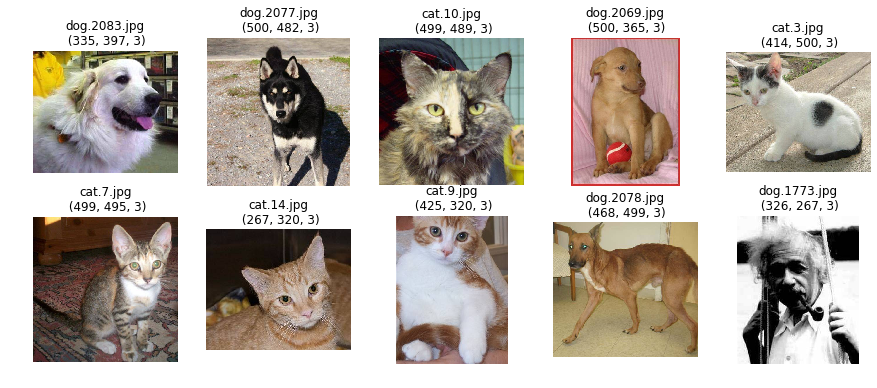

In [5]:
# 随机产生一组不重复索引列表,显示训练集中对应索引的图像
print("{} images picked randomly in training set:".format(n_show_imgs))
idx_list = np.random.choice(n_org_train_files, size=n_show_imgs, replace=False)
show_imgs(org_train_files, idx_list, True, figsize, n_cols)

10 images picked randomly in testing set:


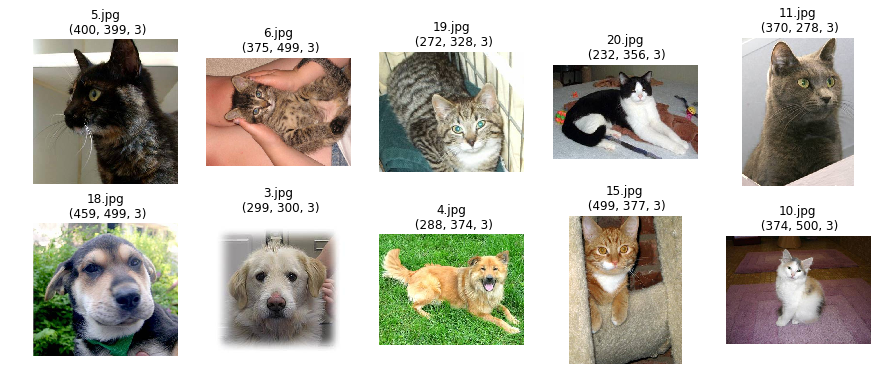

In [6]:
# 随机产生一组不重复索引列表,显示测试集中对应索引的图像
print("{} images picked randomly in testing set:".format(n_show_imgs))
idx_list = np.random.choice(n_org_test_files, size=n_show_imgs, replace=False)
show_imgs(org_test_files, idx_list, True, figsize, n_cols)

In [47]:
import pandas as pd

csv_file = working_path + os.sep + "sample_submission.csv"
df = pd.read_csv(csv_file)
print("The first 5 reocrds in {} is as bleow:".format(os.path.basename(csv_file)))
print(df.head())

The first 5 reocrds in sample_submission.csv is as bleow:
   id  label
0   1    0.5
1   2    0.5
2   3    0.5
3   4    0.5
4   5    0.5


预测结果需要输出分类概率，而不是预测的分类标签。

<a id='step2'></a>
## 步骤 2: 图像分类存放

后面的部分使用[keras.ImageDataGenerator](https://blog.csdn.net/jacke121/article/details/79245732)做预处理需要将不同种类的图片分在不同的文件夹中，这里新建train2和test2目录(避免出错后又要重新解压，所以拷贝一份出来操作）。把训练集中的猫和狗的图像拆分，分别存到train2目录中的cats和dogs子目录，测试集中的图像全部放到test2目录中的test子目录（先当成1个类做预处理，无标签）。  

使用[keras.ImageDataGenerator](https://blog.csdn.net/jacke121/article/details/79245732)做预处理[类别次序根据文件名称的字母顺序来排列](https://stackoverflow.com/questions/42868982/how-do-i-check-the-order-in-which-keras-flow-from-directory-method-processes-fo)，因此cats和dogs里面的图片会分别归为第一类和第二类，符合要求——猫的标签为0，狗的标签为1。

In [12]:
from shutil import rmtree

def create_folder(path):
    '''
    # 创建一个目录，如果目录已存在，则先删除再重新创建
    '''
    if os.path.exists(path):
        rmtree(path)
    os.mkdir(path)

In [9]:
train_path = os.path.join(working_path, "train2" + os.sep)
test_dir = os.path.join(working_path, "test2" + os.sep)

cats_train_path = os.path.join(train_path, "cats" + os.sep)
dogs_train_path = os.path.join(train_path, "dogs" + os.sep)
test_path = os.path.join(test_dir, "test" + os.sep)

# 新建train2目录，然后创建子目录cats和dogs
create_folder(train_path)
os.mkdir(cats_train_path)
os.mkdir(dogs_train_path)

# 新建test2目录
create_folder(test_dir)
os.mkdir(test_path)

In [10]:
# 一次生成batch_size个文件列表
def get_batch_objs(objs_list, batch_size):
    n_objs = len(objs_list)
    for begin in range(0, n_objs, batch_size):
        end = min(begin + batch_size, n_objs)
        yield objs_list[begin:end]

In [11]:
# 批次拷贝文件
def copy_batch_files(org_path, dest_path, files_list, batch_size=32):
    n_batches = int(ceil(len(files_list) / batch_size))
    batch_files_generator = get_batch_objs(files_list, batch_size)
    for _ in tqdm(range(n_batches), "batch copy with batch_size=" + str(batch_size)):
        for file_name in next(batch_files_generator):
            copyfile(org_path + file_name, dest_path + file_name)

In [ ]:
# 批量拷贝图片（在jupyter notebook中执行太慢，改在本地执行，训练集中前12500张为猫，后12500张为狗）
# from shutil import copyfile

# train_file_list = os.listdir(org_train_path)
# test_file_list = os.listdir(org_test_path)

# cats_file_list = [file_name for file_name in train_file_list if "cat" in file_name]
# dogs_file_list = [file_name for file_name in train_file_list if "dog" in file_name]

# copy_batch_size = 32

# copy_batch_files(org_train_path, dogs_train_path, dogs_file_list, batch_size=copy_batch_size)
# copy_batch_files(org_train_path, cats_train_path, cats_file_list, batch_size=copy_batch_size)
# copy_batch_files(org_test_path, test_path, test_file_list, batch_size=copy_batch_size)

In [13]:
# 加载数据集
dogs_train_files = np.array(glob(dogs_train_path + "*.jpg"))
cats_train_files = np.array(glob(cats_train_path + "*.jpg"))
test_files = np.array(glob(test_path + "*.jpg"))

n_dogs_train_files = dogs_train_files.size
n_cats_train_files = cats_train_files.size
n_test_files = test_files.size

# 打印数据集的数据量
print("There are total {} dog images in training set.".format(n_dogs_train_files))
print("There are total {} cat images in training set.".format(n_cats_train_files))
print("There are total {} images in testing set.".format(n_test_files))

There are total 12 dog images in training set.
There are total 12 cat images in training set.
There are total 10 images in testing set.


In [14]:
# 显示前n张图像
n_heads = 5
head_idx_list = range(n_heads)

The first 5 images of dogs and cats respectively in training set before being shuffled：


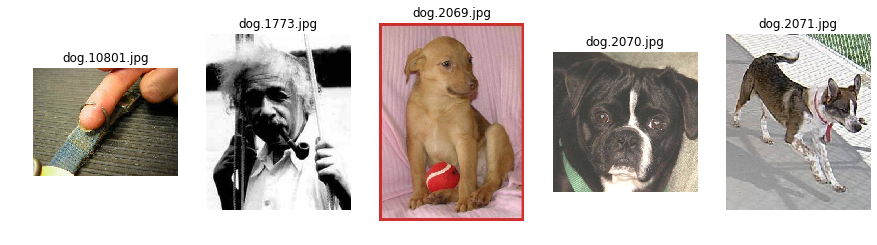

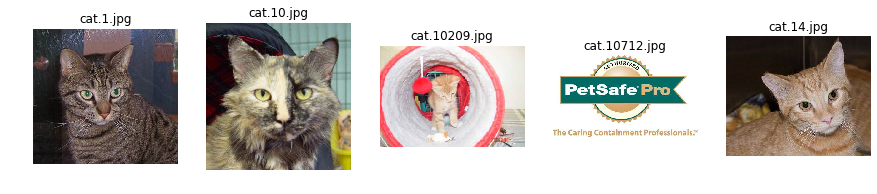

In [15]:
print("The first {} images of dogs and cats respectively in training set before being shuffled：".format(n_heads))
show_imgs(dogs_train_files, head_idx_list, False, figsize, n_cols)
show_imgs(cats_train_files, head_idx_list, False, figsize, n_cols)

<a id='step3'></a>
## 步骤 3: 异常值检测
在这个部分中，我们使用带基于[ImageNet数据集](http://www.image-net.org/)的预训练权重的[Xception](https://arxiv.org/abs/1610.02357)、[InceptionV3](https://arxiv.org/abs/1512.00567)、[ResNet50](https://arxiv.org/abs/1512.03385)模型分别去预测图像中的狗和猫（注意使用这些预训练模型训练前必须做一些预处理，比如Xception输入图像大小要求是299 x 299），然后对照[ImageNet的1000个种类清单](https://blog.csdn.net/zhangjunbob/article/details/53258524)检查Top-N的预测结果，其中Top-N以[Xception](https://arxiv.org/abs/1610.02357)的预测结果准确度来确定取Top-1还是Top-5（因为在这三个模型中，Xception的准确率最高，见下图）。     
<img src="./model_info.png"
style="width:877px;height:337px;float:center">

参考来源：
* [毕业设计 Dogs vs Cats For Udacity P7 (异常值检验)](https://zhuanlan.zhihu.com/p/34068451?edition=yidianzixun&utm_source=yidianzixun&yidian_docid=0IQskNR8)  
* [keras之预训练模型Application](https://blog.csdn.net/u010159842/article/details/79168615)
* [ResNet, AlexNet, VGG, Inception：理解各种各样的CNN架构](https://www.cnblogs.com/bonelee/p/8972139.html)

### 随机乱序
将训练集中的图片随机乱序排列，防止训练数据倾斜造成的预测结果偏差。

In [16]:
np.random.shuffle(dogs_train_files)
np.random.shuffle(cats_train_files)

The first 5 images of dogs and cats respectively in training set after being shuffled：


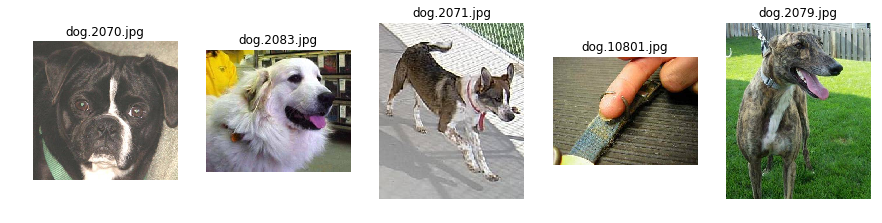

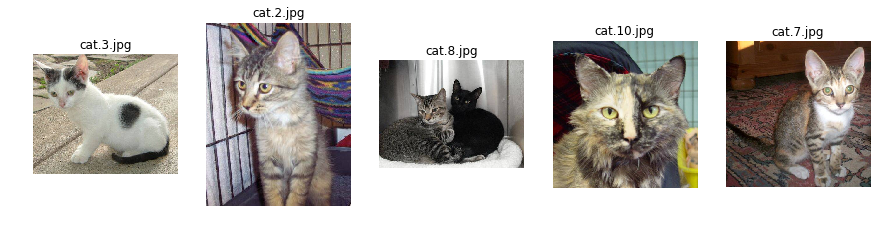

In [17]:
print("The first {} images of dogs and cats respectively in training set after being shuffled：".format(n_heads))
show_imgs(dogs_train_files, head_idx_list, False, figsize, n_cols)
show_imgs(cats_train_files, head_idx_list, False, figsize, n_cols)

下面是ImageNet数据集的1000个分类中对应为狗和猫的列表，其中狗包含118种，猫包含7种，数据来源：https://zhuanlan.zhihu.com/p/34068451?edition=yidianzixun&utm_source=yidianzixun&yidian_docid=0IQskNR8

In [18]:
dogs = [
    'n02085620','n02085782','n02085936','n02086079','n02086240','n02086646','n02086910','n02087046' 
    ,'n02087394','n02088094','n02088238','n02088364','n02088466','n02088632','n02089078','n02089867'
    ,'n02089973','n02090379','n02090622','n02090721','n02091032','n02091134','n02091244','n02091467'
    ,'n02091635','n02091831','n02092002','n02092339','n02093256','n02093428','n02093647','n02093754'
    ,'n02093859','n02093991','n02094114','n02094258','n02094433','n02095314','n02095570','n02095889'
    ,'n02096051','n02096177','n02096294','n02096437','n02096585','n02097047','n02097130','n02097209'
    ,'n02097298','n02097474','n02097658','n02098105','n02098286','n02098413','n02099267','n02099429'
    ,'n02099601','n02099712','n02099849','n02100236','n02100583','n02100735','n02100877','n02101006'
    ,'n02101388','n02101556','n02102040','n02102177','n02102318','n02102480','n02102973','n02104029'
    ,'n02104365','n02105056','n02105162','n02105251','n02105412','n02105505','n02105641','n02105855'
    ,'n02106030','n02106166','n02106382','n02106550','n02106662','n02107142','n02107312','n02107574'
    ,'n02107683','n02107908','n02108000','n02108089','n02108422','n02108551','n02108915','n02109047'
    ,'n02109525','n02109961','n02110063','n02110185','n02110341','n02110627','n02110806','n02110958'
    ,'n02111129','n02111277','n02111500','n02111889','n02112018','n02112137','n02112350','n02112706'
    ,'n02113023','n02113186','n02113624','n02113712','n02113799','n02113978']

cats=[
    'n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']

In [19]:
from keras.preprocessing import image

def path_to_tensor(img_path, target_size=(299, 299)):
    '''
    # 将一张图像转为(1, target_width, target_height,target_depth)的4维张量并返回
    # 彩色图片有RGB三个通道，所以深度为3
    '''
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=target_size)
    # 默认将PIL.Image.Image类型转化为格式为((299, 299, 3)的3维张量
    x = image.img_to_array(img)
    # 默认将3维张量转化为格式为(1, 299, 299 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, target_size=(299, 299)):
    '''
    # 将图片列表中的图片都转为指定shape的4维张量然后合并为一个数组返回
    '''
    list_of_tensors = [path_to_tensor(img_path, target_size) for img_path in img_paths]
    return np.vstack(list_of_tensors)

Using TensorFlow backend.


In [20]:
# 对照ImageNet的1000个分类列表检查预测结果
def dogs_and_cats_detector(y_preds, check_list):
    n_preds = len(y_preds)
    results = np.full(n_preds, True, dtype=bool) 
    for i in range(n_preds):
        for y_pred in y_preds[i]:
            result = True
            if y_pred[0] in check_list:
                break
        else:
            results[i] = False
    return list(results)

In [21]:
# 分批预测，并对照ImageNet数据集的列表检查是否预测准确
def model_predict_and_check(dogs, cats, model, preprocess_input, decode_predictions, target_size=(299, 299), batch_size=64, topN=5):
    # 这里猫狗的图片数量相等，所以随意取了狗的数量
    n_batches = int(ceil(n_dogs_train_files / batch_size))
    
    y_preds_dogs = []
    y_preds_cats = []
    results_dogs = []
    results_cats = []
    
    batch_dogs_generator = get_batch_objs(dogs_train_files, batch_size)
    batch_cats_generator = get_batch_objs(cats_train_files, batch_size)
    
    for i in tqdm(range(n_batches), "batch predict and check with batch_size=" + str(batch_size)):
        batch_preds_dogs = decode_predictions(model.predict(
                                preprocess_input(paths_to_tensor(next(batch_dogs_generator), target_size))),
                                top=topN)
        batch_preds_cats = decode_predictions(model.predict(
                                preprocess_input(paths_to_tensor(next(batch_cats_generator), target_size))),
                                top=topN)   
        batch_results_dogs = dogs_and_cats_detector(batch_preds_dogs, dogs)
        batch_results_cats = dogs_and_cats_detector(batch_preds_cats, cats)
        
        y_preds_dogs.extend(batch_preds_dogs)
        y_preds_cats.extend(batch_preds_cats)
        results_dogs.extend(batch_results_dogs)
        results_cats.extend(batch_results_cats)
        
    return y_preds_dogs, y_preds_cats, results_dogs, results_cats

In [22]:
check_batch_size = 64

In [23]:
from keras.applications.xception import Xception, preprocess_input, decode_predictions

model = Xception(weights="imagenet")
model_name = "Xception"
target_size = (299, 299)

In [24]:
topN = 1
y_preds_dogs, y_preds_cats, results_dogs, results_cats = model_predict_and_check(dogs, cats,
                                                                                 model, preprocess_input, decode_predictions, 
                                                                                 target_size=target_size, 
                                                                                 batch_size=check_batch_size, 
                                                                                 topN=topN)

batch predict and check with batch_size=5: 100%|█| 3/3 [00:18<00:00,  6.47s/it]


In [25]:
error_idx_dogs_Xception = [idx for idx,value in enumerate(results_dogs) if not value]
error_idx_cats_Xception = [idx for idx,value in enumerate(results_cats) if not value]

Xception Top-1 predicts: There are 3 false dogs.


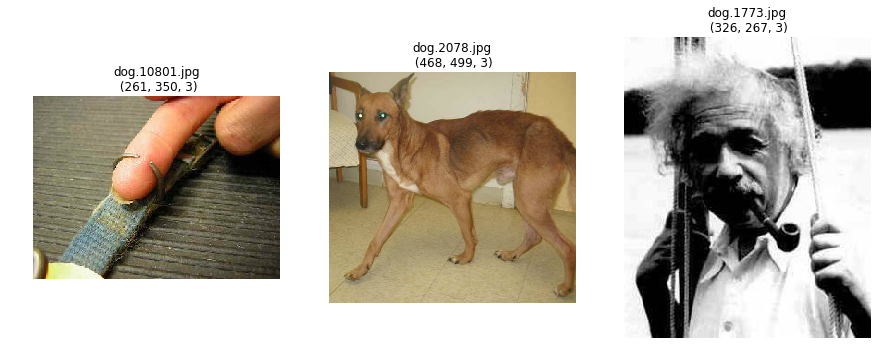

In [26]:
print("{} Top-{} predicts: There are {} false dogs.".format(model_name, topN, len(error_idx_dogs_Xception)))
show_imgs(dogs_train_files, error_idx_dogs_Xception, True)

Xception Top-1 predicts: There are 2 false cats.


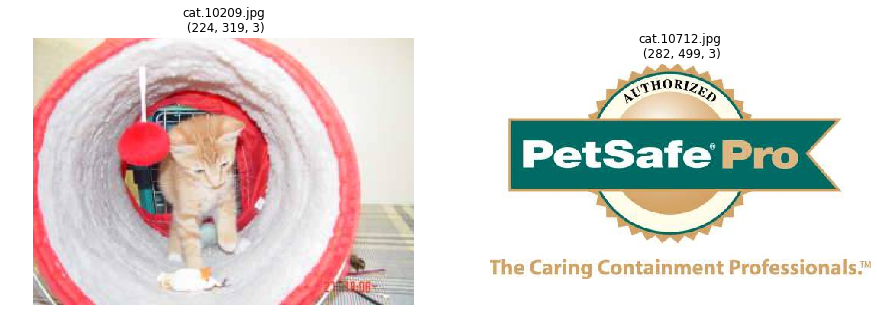

In [27]:
print("{} Top-{} predicts: There are {} false cats.".format(model_name, topN, len(error_idx_cats_Xception)))
show_imgs(cats_train_files, error_idx_cats_Xception, True)

In [28]:
topN = 5
y_preds_dogs, y_preds_cats, results_dogs, results_cats = model_predict_and_check(dogs, cats,
                                                                                 model, preprocess_input, decode_predictions, 
                                                                                 target_size=target_size, 
                                                                                 batch_size=check_batch_size, 
                                                                                 topN=topN)

batch predict and check with batch_size=5: 100%|█| 3/3 [00:18<00:00,  6.31s/it]


In [29]:
error_idx_dogs_Xception = [idx for idx,value in enumerate(results_dogs) if not value]
error_idx_cats_Xception = [idx for idx,value in enumerate(results_cats) if not value]

Xception Top-5 predicts: There are 2 false dogs.


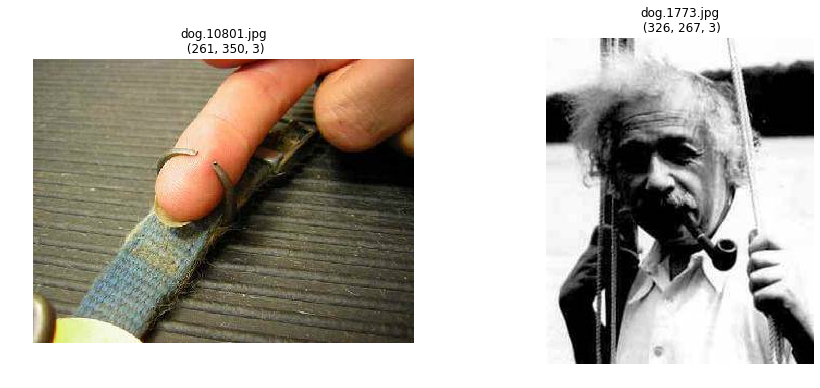

In [30]:
print("{} Top-{} predicts: There are {} false dogs.".format(model_name, topN, len(error_idx_dogs_Xception)))
show_imgs(dogs_train_files, error_idx_dogs_Xception, True)

Xception Top-5 predicts: There are 2 false cats.


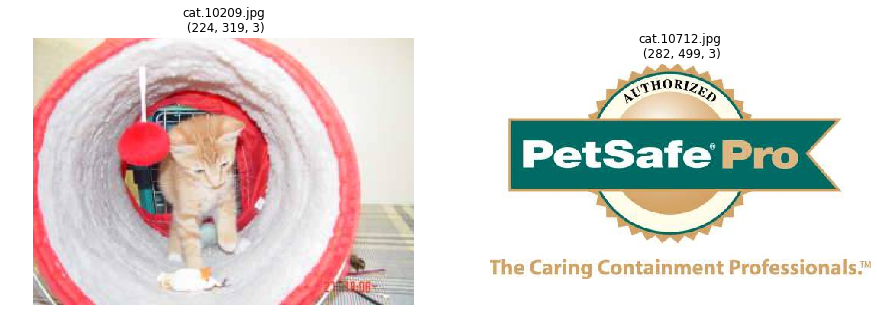

In [31]:
print("{} Top-{} predicts: There are {} false cats.".format(model_name, topN, len(error_idx_cats_Xception)))
show_imgs(cats_train_files, error_idx_cats_Xception, True)

根据上面的对比，选择topN = 5，上面最后输出的就是Xception的Top-5预测，不需要重新跑一遍了。

In [32]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

model = InceptionV3(weights="imagenet")
model_name = "InceptionV3"
target_size = (299, 299)

In [33]:
y_preds_dogs, y_preds_cats, results_dogs, results_cats = model_predict_and_check(dogs, cats,
                                                                                 model, preprocess_input, decode_predictions, 
                                                                                 target_size=target_size, 
                                                                                 batch_size=check_batch_size, 
                                                                                 topN=topN)

batch predict and check with batch_size=5: 100%|█| 3/3 [00:09<00:00,  3.50s/it]


In [34]:
error_idx_dogs_InceptionV3 = [idx for idx,value in enumerate(results_dogs) if not value]
error_idx_cats_InceptionV3 = [idx for idx,value in enumerate(results_cats) if not value]

InceptionV3 Top-5 predicts: There are 2 false dogs.


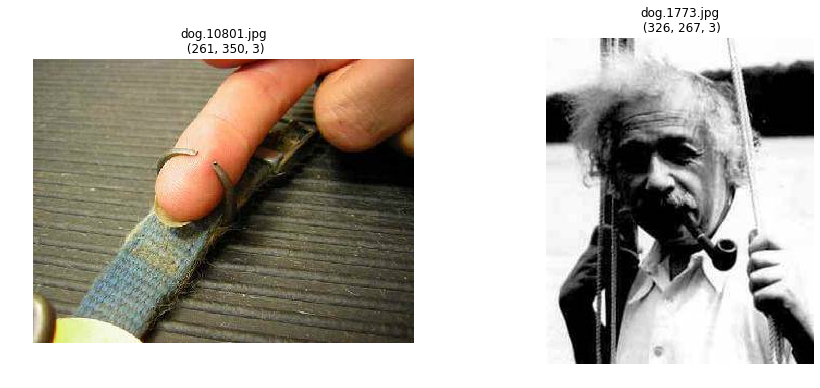

In [35]:
print("{} Top-{} predicts: There are {} false dogs.".format(model_name, topN, len(error_idx_dogs_InceptionV3)))
show_imgs(dogs_train_files, error_idx_dogs_InceptionV3, True)

InceptionV3 Top-5 predicts: There are 3 false cats.


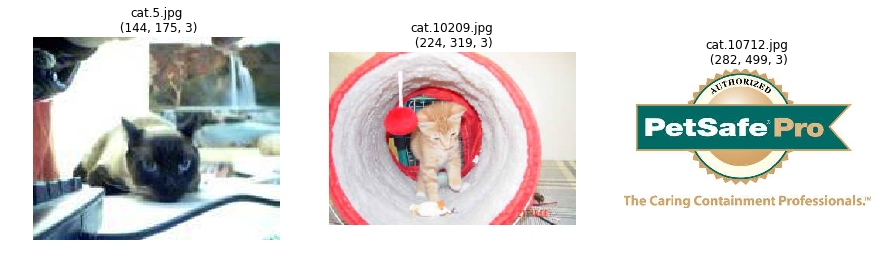

In [36]:
print("{} Top-{} predicts: There are {} false cats.".format(model_name, topN, len(error_idx_cats_InceptionV3)))
show_imgs(cats_train_files, error_idx_cats_InceptionV3, True)

In [37]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights="imagenet")
model_name = "ResNet50"
target_size = (224, 224)

In [38]:
y_preds_dogs, y_preds_cats, results_dogs, results_cats = model_predict_and_check(dogs, cats,
                                                                                 model, preprocess_input, decode_predictions, 
                                                                                 target_size=target_size, 
                                                                                 batch_size=check_batch_size, 
                                                                                 topN=topN)

batch predict and check with batch_size=5: 100%|█| 3/3 [00:10<00:00,  3.61s/it]


In [39]:
error_idx_dogs_ResNet50 = [idx for idx,value in enumerate(results_dogs) if not value]
error_idx_cats_ResNet50 = [idx for idx,value in enumerate(results_cats) if not value]

ResNet50 Top-5 predicts: There are 2 false dogs.


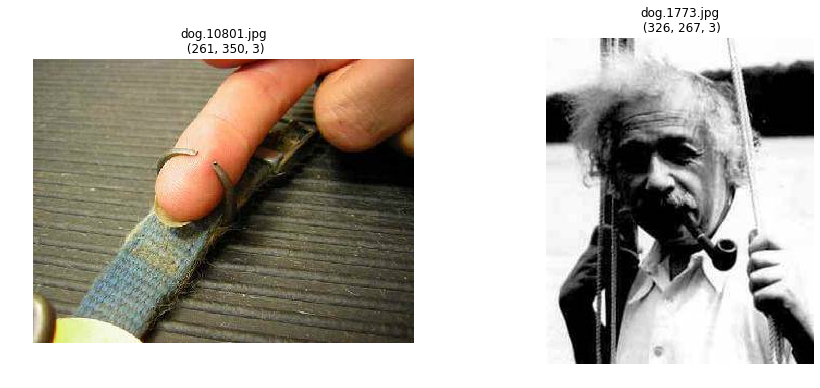

In [40]:
print("{} Top-{} predicts: There are {} false dogs.".format(model_name, topN, len(error_idx_dogs_ResNet50)))
show_imgs(dogs_train_files, error_idx_dogs_ResNet50, True)

ResNet50 Top-5 predicts: There are 3 false cats.


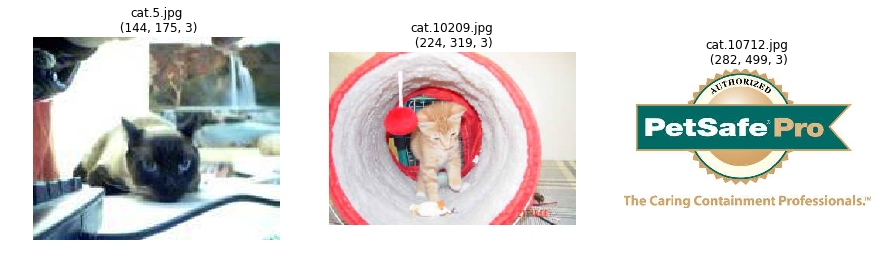

In [41]:
print("{} Top-{} predicts: There are {} false cats.".format(model_name, topN, len(error_idx_cats_ResNet50)))
show_imgs(cats_train_files, error_idx_cats_ResNet50, True)

In [42]:
# 求交集
error_idx_dogs = list(set(error_idx_dogs_Xception) & set(error_idx_dogs_InceptionV3) & set(error_idx_dogs_ResNet50))
error_idx_cats = list(set(error_idx_cats_Xception) & set(error_idx_cats_InceptionV3) & set(error_idx_cats_ResNet50))

Esembel(Xception/InceptionV3/ResNet50) Top-5 predicts: There are 2 false dogs.


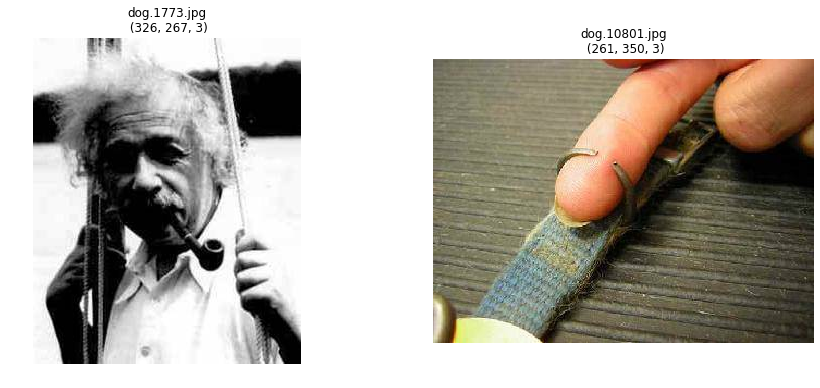

In [43]:
print("Esembel(Xception/InceptionV3/ResNet50) Top-{} predicts: There are {} false dogs.".format(topN, len(error_idx_dogs)))
show_imgs(dogs_train_files, error_idx_dogs, True)

Esembel(Xception/InceptionV3/ResNet50) Top-5 predicts: There are 2 false cats.


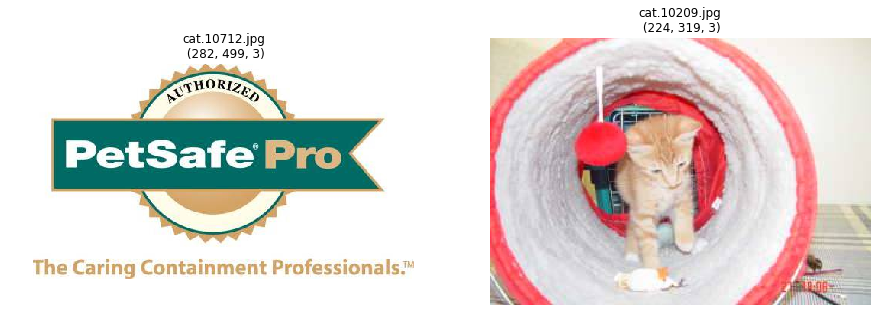

In [44]:
print("Esembel(Xception/InceptionV3/ResNet50) Top-{} predicts: There are {} false cats.".format(topN, len(error_idx_cats)))
show_imgs(cats_train_files, error_idx_cats, True)

<a id='step4'></a>
## 步骤 4: 数据集预处理

### 剔除异常值

In [46]:
from shutil import move

# 在train2下面新建一个error_files用来保存错误的图片（不区分猫狗）
error_files_path = os.path.join(train_path, "error_files" + os.sep)
create_folder(error_files_path)

# 分批移动错误图片
def move_error_files(error_idx_list, files_list, batch_size=32):
    # 用另外的变量保存，因为索引跟图片没有强相关，多次执行会不断迭代
    update_files_list = [item for idx, item in enumerate(files_list) if idx not in error_idx_list]
    n_batches = int(ceil(len(error_idx_list) / batch_size))
    batch_idx_generator = get_batch_objs(error_idx_list, batch_size)
    for _ in tqdm(range(n_batches), "batch move with batch_size=" + str(batch_size)):
        for idx in next(batch_idx_generator):
            if (os.path.isfile(files_list[idx])):
                move(files_list[idx], error_files_path)
    return update_files_list

move_batch_size = 32
dogs_train = move_error_files(error_idx_dogs, dogs_train_files, move_batch_size)
cats_train = move_error_files(error_idx_cats, cats_train_files, move_batch_size)

batch move with batch_size=5: 100%|█████████████| 1/1 [00:00<00:00, 111.11it/s]


In [47]:
print(os.listdir(error_files_path))

['cat.10209.jpg', 'cat.10712.jpg', 'dog.10801.jpg', 'dog.1773.jpg']


### 提取特征向量并保存
使用[迁移学习](http://arxiv.org/abs/1411.1792)，分别利用基于[ImageNet数据集](http://www.image-net.org/)预训练的[Xception](https://arxiv.org/abs/1610.02357)、[InceptionV3](https://arxiv.org/abs/1512.00567)、[ResNet50](https://arxiv.org/abs/1512.03385)模型（不包含顶层的全连接层）提取训练集和测试集图像的特征向量并保存，注意图像输入模型前需要进行预处理，这里使用[keras.ImageDataGenerator](https://blog.csdn.net/jacke121/article/details/79245732)。

In [ ]:
### from keras.layers import Input, Lambda, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import *
import h5py

gen_batch_size = 64

h5_path = os.path.join(working_path, "h5files" + os.sep)
create_folder(h5_path)

def write_gap(model_name, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input(shape=(height, width, 3))
    x = input_tensor
  
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = eval(model_name)(input_tensor=x, weights="imagenet", include_top=False)
    model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))
  
    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(train_path, image_size, shuffle=False, batch_size=gen_batch_size)
    test_generator = gen.flow_from_directory(test_dir, image_size, shuffle=False, batch_size=gen_batch_size, class_mode=None)

    n_train_steps = int(ceil(train_generator.samples / gen_batch_size))
    n_test_steps = int(ceil(test_generator.samples / gen_batch_size))
    
    train = model.predict_generator(train_generator, n_train_steps)
    test = model.predict_generator(test_generator, n_test_steps)
  
    with h5py.File(h5_path + "gap_{}.h5".format(model_name), "w") as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [59]:
from time import time
start_time = time()
write_gap("Xception", (299, 299), xception.preprocess_input)
end_time = time()
print("Seconds of extracting features by Xception: {}".format(end_time - start_time))

Found 24 images belonging to 3 classes.
Found 10 images belonging to 1 classes.
Seconds of extracting features by Xception: 59.34939455986023


In [60]:
start_time = time()
write_gap("InceptionV3", (299, 299), inception_v3.preprocess_input)
end_time = time()
print("Seconds of extracting features by InceptionV3: {}".format(end_time - start_time))

Found 24 images belonging to 3 classes.
Found 10 images belonging to 1 classes.
Seconds of extracting features by InceptionV3: 54.49211668968201


In [61]:
start_time = time()
write_gap("ResNet50", (224, 224))
end_time = time()
print("Seconds of extracting features by ResNet50: {}".format(end_time - start_time))

D:\Program Files\Anaconda3\envs\mldn\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 24 images belonging to 3 classes.
Found 10 images belonging to 1 classes.
Seconds of extracting features by ResNet50: 47.74273061752319


<a id='step5'></a>
## 步骤 5: 模型构建与训练
使用[集成方法](https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf)把多个弱学习器模型变成一个强学习器模型，可以显著提高模型的准确率与鲁棒性。这里把上一步预处理中从训练集和测试集提取的[Xception的特征向量](https://github.com/ypwhs/dogs_vs_cats/releases/download/gap/gap_Xception.h5)、[InceptionV3的特征向量](https://github.com/ypwhs/dogs_vs_cats/releases/download/gap/gap_InceptionV3.h5)、[ResNet50的特征向量](https://github.com/ypwhs/dogs_vs_cats/releases/download/gap/gap_ResNet50.h5)分别合成。建立一个CNN模型网络，并将合成的训练集的特征向量输入进行训练。

### 提取特征向量

In [2]:
from sklearn.utils import shuffle

h5_files = np.array(glob(h5_path + "*.h5"))

X_train = []
X_test = []

for file_name in h5_files:
    with h5py.File(file_name, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

### 模型架构

In [3]:
from keras.layers import Dropout, Dense

# 定义网络框架
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=input_tensor, outputs=x)
           
# 输出网络框架     
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6144)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6144)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6145      
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 超参
optimizer="Adagrad"

# 编译模型 
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

keras模型可视化参考: [https://keras-cn.readthedocs.io/en/latest/other/visualization/](https://keras-cn.readthedocs.io/en/latest/other/visualization/)。  
**注意**：这里可视化依赖pydot和grahviz包，并且需要先在本地下载安装[GraphVizhttps](https://graphviz.gitlab.io/download/)并将它的bin目录加到PATH环境变量，否则会踩[**坑**](https://blog.csdn.net/u011311291/article/details/80298563)。

In [ ]:
# 可视化模型
from keras.utils import plot_model

# plot_model(model, to_file="model.png")

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog="dot", format="svg"))

### 训练模型

In [36]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 使用模型检查点（model checkpointing）来储存具有最低验证集 loss 的模型。
saved_models_path = os.path.join(working_path, "saved_models" + os.sep)
create_folder(saved_models_path)

hdf5_adagrad = saved_models_path + "weights.best.adagrad.hdf5"
checkpointer = ModelCheckpoint(hdf5_adagrad, verbose=1, save_best_only=True)

In [37]:
# 超参
epochs = 8
train_batch_size = 128

# 训练集的20%用做交叉验证
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=epochs, batch_size=train_batch_size, 
                    callbacks=[checkpointer], verbose=1)

Train on 19 samples, validate on 5 samples
Epoch 1/8
19/19 [==============================] - 0s 7ms/step - loss: -2.5130 - acc: 0.8421 - val_loss: 3.2897 - val_acc: 0.2000

Epoch 00001: val_loss improved from inf to 3.28971, saving model to E:\dogs_vs_cats\saved_models\weights.best.adagrad.hdf5
Epoch 2/8
19/19 [==============================] - 0s 211us/step - loss: -0.0226 - acc: 0.4737 - val_loss: 7.2241e-06 - val_acc: 0.6000

Epoch 00002: val_loss improved from 3.28971 to 0.00001, saving model to E:\dogs_vs_cats\saved_models\weights.best.adagrad.hdf5
Epoch 3/8
19/19 [==============================] - 0s 263us/step - loss: -2.3927 - acc: 0.7895 - val_loss: -0.4901 - val_acc: 0.6000

Epoch 00003: val_loss improved from 0.00001 to -0.49006, saving model to E:\dogs_vs_cats\saved_models\weights.best.adagrad.hdf5
Epoch 4/8
19/19 [==============================] - 0s 211us/step - loss: -2.5162 - acc: 0.8421 - val_loss: -0.5034 - val_acc: 0.6000

Epoch 00004: val_loss improved from -0.4900

下面的函数实现loss和accuracy的可视化，参考：[可视化keras模型训练历史](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)

In [38]:
# 绘制准确率和loss曲线图
def show_loss_and_acc():
    
    plt.plot(history.history['loss'], 'blue', label='Training Loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'], 'blue', label='Training Accuracy')
    plt.plot(history.history['val_acc'], 'green', label='Validation Accuracy')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
 
    plt.show()

current hyperparameters of the model: epochs=8, batch_size=128, optimizer=Adagrad


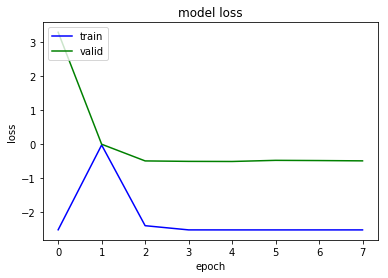

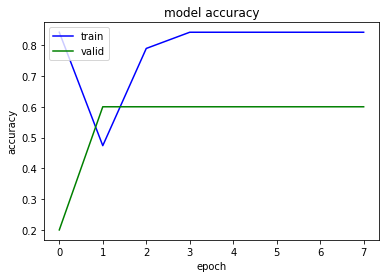

In [39]:
print("current hyperparameters of the model: epochs={}, batch_size={}, optimizer={}".format(epochs, train_batch_size, optimizer))
# 可视化loss和accuracy曲线
show_loss_and_acc()

<a id='step6'></a>
## 步骤 6: 模型改进
[adadelta优化器](https://arxiv.org/abs/1212.5701)是[Adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)的一个具有更强鲁棒性的的扩展版本，它不是累积所有过去的梯度，而是根据渐变更新的移动窗口调整学习速率。  
更多优化器介绍参考: [https://keras.io/zh/optimizers/](https://keras.io/zh/optimizers/)。

Train on 19 samples, validate on 5 samples
Epoch 1/8
19/19 [==============================] - 0s 9ms/step - loss: -2.5164 - acc: 0.8421 - val_loss: -0.4709 - val_acc: 0.6000

Epoch 00001: val_loss improved from inf to -0.47087, saving model to E:\dogs_vs_cats\saved_models\weights.best.adadelta.hdf5
Epoch 2/8
19/19 [==============================] - 0s 316us/step - loss: -2.5169 - acc: 0.8421 - val_loss: -0.4644 - val_acc: 0.6000

Epoch 00002: val_loss did not improve from -0.47087
Epoch 3/8
19/19 [==============================] - 0s 316us/step - loss: -2.5166 - acc: 0.8421 - val_loss: -0.4562 - val_acc: 0.6000

Epoch 00003: val_loss did not improve from -0.47087
Epoch 4/8
19/19 [==============================] - 0s 526us/step - loss: -2.5171 - acc: 0.8421 - val_loss: -0.4581 - val_acc: 0.6000

Epoch 00004: val_loss did not improve from -0.47087
Epoch 5/8
19/19 [==============================] - 0s 368us/step - loss: -2.5170 - acc: 0.8421 - val_loss: -0.4618 - val_acc: 0.6000

Epoch 00

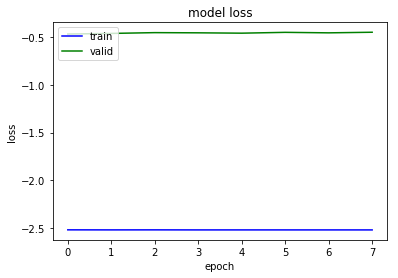

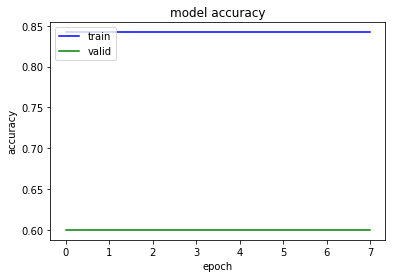

In [41]:
optimizer="adadelta" 
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

hdf5_adadelta = saved_models_path + "weights.best.adadelta.hdf5"
checkpointer = ModelCheckpoint(hdf5_adadelta, verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=epochs, batch_size=train_batch_size, 
                    callbacks=[checkpointer], verbose=1)

print("current hyperparameters of the model: epochs={}, batch_size={}, optimizer={}".format(epochs, train_batch_size, optimizer))
show_loss_and_acc()

<a id='step7'></a>
## 步骤 7: 模型预测与评估
这里仅做预测并输出到preds.csv，需要将结果提交到[Kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/submit)上查看得分。

In [42]:
# 加载具有最好验证loss的模型
model.load_weights(hdf5_adadelta)

In [45]:
# 预测测试集的分类概率（狗的类别是1，猫的类别是0）
y_preds = model.predict(X_test, verbose=1)

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(test_dir, (224, 224), shuffle=False, batch_size=gen_batch_size, class_mode=None)

10/10 [==============================] - 0s 100us/step
Found 10 images belonging to 1 classes.


In [48]:
# 按格式输出预测结果到preds.csv
for i, file_name in enumerate(test_generator.filenames):
    file_id = int(file_name.split(".")[0].rsplit(os.sep)[-1])
    df.loc[i] = [file_id, y_preds[i]]

preds_file = "preds.csv"
df.to_csv(preds_file, index=None)

In [54]:
print("The first {} reocrds in {} is as bleow:".format(n_heads, os.path.basename(preds_file)))
print(df.head(n_heads))

The first 5 reocrds in preds.csv is as bleow:
   id     label
0  10  0.016322
1  11  0.000981
2  15  0.001786
3  18  0.999976
4  19  0.002377


猫的标签为0，狗的标签为1，所以输出的概率越接近0就会被预测为猫，更接近1就会被预测为狗。

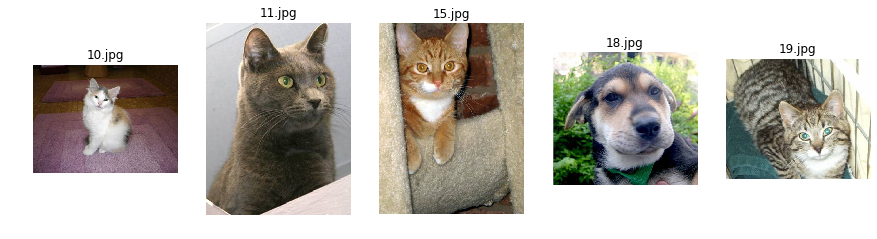

In [55]:
show_imgs(test_files, head_idx_list, False, figsize, n_cols)